In [3]:
# 从数据库导入数据dfpbroech6
import pandas as pd
from sqlalchemy import create_engine

# 根据你的实际数据库信息填写
username = "panjinhe"
password = "20020112p"
host = "localhost"
port = "5432"
database = "pbroe"

# 定义要查询的表和schema
table_name = 'pbroech4'
schema_name = 'pbroe'

# 定义日期范围
start_date = '2005-04'
end_date = '2025-03'

# 构建连接字符串
connection_string = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

# 创建引擎
engine = create_engine(connection_string)

# 构建带有日期范围筛选的SQL查询语句
# 这样可以在数据库层面直接过滤，效率更高
sql_query = f"""
SELECT * FROM {schema_name}.{table_name}
WHERE "trdmnt" >= '{start_date}' AND "trdmnt" <= '{end_date}'
"""
# 使用 pd.read_sql_query 执行带有条件的查询
dfpbroech6 = pd.read_sql_query(sql_query, engine)

# print("\n数据加载成功！")
# # --- 3. 显示数据信息 ---
# print("\nDataFrame Info:")
print(dfpbroech6.info())
# print("\nDataFrame Head (first 10 rows):")
#display(dfpbroech6.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666516 entries, 0 to 666515
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   stkcd          666516 non-null  object 
 1   trdmnt         666516 non-null  object 
 2   accper         666516 non-null  object 
 3   shortname      666516 non-null  object 
 4   if_st          666516 non-null  int64  
 5   indcd1         666516 non-null  object 
 6   indnme1        666516 non-null  object 
 7   price          666516 non-null  float64
 8   market_cap     666516 non-null  float64
 9   total_shares   666516 non-null  float64
 10  eps_ttm_core   611261 non-null  float64
 11  eps_ttm_total  635140 non-null  float64
 12  roe_ttm        633763 non-null  float64
 13  total_equity   666516 non-null  float64
 14  ar             666516 non-null  float64
 15  inventory      666516 non-null  float64
 16  intangibles    666516 non-null  float64
 17  onaps          666516 non-nul

In [2]:
# 获取ch5的组合文件
import pandas as pd
from pathlib import Path

def generate_pbroe5_holdings(
    file_p3_residuals: Path,
    file_p4_residuals: Path,
    file_p3_ts_quantiles: Path,
    output_file: Path,
    ts_quantile_col: str,
    cross_sectional_quantile: float,
    time_series_quantile_threshold: float,
    start_date: str,
    end_date: str
) -> None:
    """
    构建 PBROE 5.0 策略的投资组合，并生成包含详细信息的持仓文件。

    该函数执行以下步骤：
    1. 加载 PBROE 3.1 残差数据、PBROE 4.1 残差数据以及包含时序分位数的数据。
    2. 根据指定的日期范围过滤数据。
    3. 在每个调仓日，找出同时满足以下三个条件的股票：
       - PBROE 3.1 横截面残差低于指定分位数。
       - PBROE 4.1 横截面残差低于指定分位数。
       - 基于 PBROE 3.1 残差计算的时序分位数低于指定阈值。
    4. 将筛选出的股票（即投资组合）与详细信息合并。
    5. 保存包含所有要求字段的最终持仓文件。

    参数:
        file_p3_residuals (Path): pbroe3.1 原始残差数据文件的路径。
        file_p4_residuals (Path): pbroe4.1 原始残差数据文件的路径。
        file_p3_ts_quantiles (Path): 包含基于 pbroe3.1 的时序残差分位数数据的文件路径。
                                     该文件应包含所有需要的最终输出列。
        output_file (Path): 输出的持仓 CSV 文件的路径 (必须是完整的文件路径，包含文件名)。
        ts_quantile_col (str): 要使用的时序残差分位数列的名称 (例如 'residual_quantile_10m')。
        cross_sectional_quantile (float): 横截面残差的筛选百分位数阈值。
        time_series_quantile_threshold (float): 时序残差分位数的筛选阈值。
        start_date (str): 回测开始日期 (YYYY-MM-DD)。
        end_date (str): 回测结束日期 (YYYY-MM-DD)。
    """
    print("--- 开始生成 PBROE 5.0 策略持仓文件 ---")

    try:
        # --- 步骤 1: 加载并预处理数据 ---
        print("加载数据文件中...")
        start_ts = pd.to_datetime(start_date)
        end_ts = pd.to_datetime(end_date)

        # 加载 pbroe3.1 残差数据
        df_p3 = pd.read_csv(file_p3_residuals)
        df_p3['stkcd'] = df_p3['stkcd'].astype(str).str.zfill(6)
        df_p3['调入日期'] = pd.to_datetime(df_p3['调入日期'])
        df_p3 = df_p3[(df_p3['调入日期'] >= start_ts) & (df_p3['调入日期'] <= end_ts)].copy()

        # 加载 pbroe4.1 残差数据
        df_p4 = pd.read_csv(file_p4_residuals)
        df_p4['stkcd'] = df_p4['stkcd'].astype(str).str.zfill(6)
        df_p4['调入日期'] = pd.to_datetime(df_p4['调入日期'])
        df_p4 = df_p4[(df_p4['调入日期'] >= start_ts) & (df_p4['调入日期'] <= end_ts)].copy()

        # 加载包含时序分位数和所有详细信息的 pbroe3.1 数据
        df_ts_details = pd.read_csv(file_p3_ts_quantiles)
        df_ts_details['stkcd'] = df_ts_details['stkcd'].astype(str).str.zfill(6)
        df_ts_details['调入日期'] = pd.to_datetime(df_ts_details['调入日期'])
        df_ts_details = df_ts_details[(df_ts_details['调入日期'] >= start_ts) & (df_ts_details['调入日期'] <= end_ts)].copy()

        print(f"数据加载并按日期过滤成功。")
        print(f"p3 记录数: {len(df_p3)}, p4 记录数: {len(df_p4)}, 时序细节记录数: {len(df_ts_details)}")

    except FileNotFoundError as e:
        print(f"错误: 找不到数据文件 {e.filename}。请检查路径。")
        return
    except KeyError as e:
        print(f"错误: 文件中未找到关键列 '{e}'。")
        return

    # --- 步骤 2: 寻找共同调仓日期并构建投资组合 ---
    common_dates = sorted(list(set(df_p3['调入日期']) & set(df_p4['调入日期']) & set(df_ts_details['调入日期'])))
    print(f"在 {start_date} 到 {end_date} 期间找到 {len(common_dates)} 个共同的调仓日期。")

    portfolio_list = []
    for date in common_dates:
        # 筛选 pbroe3.1 低残差股票
        group3 = df_p3[df_p3['调入日期'] == date]
        if group3.empty: continue
        threshold3 = group3['residual_zscore'].quantile(cross_sectional_quantile)
        portfolio3_stocks = set(group3[group3['residual_zscore'] <= threshold3]['stkcd'])

        # 筛选 pbroe4.1 低残差股票
        group4 = df_p4[df_p4['调入日期'] == date]
        if group4.empty: continue
        threshold4 = group4['residual_zscore_adj'].quantile(cross_sectional_quantile)
        portfolio4_stocks = set(group4[group4['residual_zscore_adj'] <= threshold4]['stkcd'])

        # 筛选时序残差分位数低于阈值的股票
        group_ts = df_ts_details[df_ts_details['调入日期'] == date]
        if group_ts.empty: continue
        portfolio_ts_stocks = set(group_ts[group_ts[ts_quantile_col] <= time_series_quantile_threshold]['stkcd'])

        # 取三个集合的交集
        intersection_stocks = list(portfolio3_stocks.intersection(portfolio4_stocks).intersection(portfolio_ts_stocks))

        if intersection_stocks:
            temp_df = pd.DataFrame({'调入日期': date, 'stkcd': intersection_stocks})
            portfolio_list.append(temp_df)

    if not portfolio_list:
        print("错误：未能构建任何有效的投资组合。可能是筛选条件过严或数据缺失。")
        return

    # 合并所有调仓日的持仓
    portfolio_keys = pd.concat(portfolio_list, ignore_index=True)
    print(f"已成功构建 PBROE 5.0 投资组合，共包含 {len(portfolio_keys)} 条持仓记录。")

    # --- 步骤 3: 合并详细信息并保存 ---
    print("合并持仓股票的详细信息...")
    # 定义最终需要的列
    final_columns = [
        '调入日期', 'stkcd', 'shortname', 'indnme1', 'ROEttm', 'PB',
        'residual_zscore', 'residual_quantile_10m', 'residual_quantile_20m',
        'residual_quantile_50m'
    ]

    missing_cols = [col for col in final_columns if col not in df_ts_details.columns]
    if missing_cols:
        print(f"错误: 详细信息文件 '{file_p3_ts_quantiles.name}' 中缺少以下必需列: {missing_cols}")
        return

    holdings_df = pd.merge(portfolio_keys, df_ts_details, on=['调入日期', 'stkcd'], how='inner')
    final_holdings_df = holdings_df[final_columns].sort_values(by=['调入日期', 'stkcd']).reset_index(drop=True)

    # **修正点**: 在写入前，确保输出目录存在
    try:
        output_file.parent.mkdir(parents=True, exist_ok=True)
        final_holdings_df.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"--- 持仓文件已成功生成 ---")
        print(f"文件保存在: {output_file}")
        print(f"总持仓条目数: {len(final_holdings_df)}")
        print("\n文件内容预览:")
        print(final_holdings_df.head())
    except Exception as e:
        print(f"错误：保存文件到 '{output_file}' 时失败。错误信息: {e}")


if __name__ == '__main__':
    # --- 配置参数 ---
    # **修正点**: 为 output_file 提供一个完整的文件路径，包括文件名和扩展名
    output_dir = Path('E:/PBROE/ch6')
    strategy_name = 'PBROE_5.0_from_3.1_TS_10M'

    config = {
        'file_p3_residuals': Path('E:/PBROE/ch3/pbroe3.1Residuals.csv'),
        'file_p4_residuals': Path('E:/PBROE/ch4/pbroe4.1Residuals.csv'),
        'file_p3_ts_quantiles': Path('E:/PBROE/ch5/pbroe3.1Residuals_with_quantiles.csv'),
        'output_file': output_dir / f'{strategy_name}_holdings.csv', # 修正后的文件路径
        'ts_quantile_col': 'residual_quantile_10m',
        'cross_sectional_quantile': 0.2,
        'time_series_quantile_threshold': 0.2,
        'start_date': '2010-05-01',
        'end_date': '2025-04-30'
    }

    # --- 执行函数 ---
    generate_pbroe5_holdings(**config)


--- 开始生成 PBROE 5.0 策略持仓文件 ---
加载数据文件中...
数据加载并按日期过滤成功。
p3 记录数: 499809, p4 记录数: 458508, 时序细节记录数: 499809
在 2010-05-01 到 2025-04-30 期间找到 180 个共同的调仓日期。
已成功构建 PBROE 5.0 投资组合，共包含 20671 条持仓记录。
合并持仓股票的详细信息...
--- 持仓文件已成功生成 ---
文件保存在: E:\PBROE\ch6\PBROE_5.0_from_3.1_TS_10M_holdings.csv
总持仓条目数: 20671

文件内容预览:
        调入日期   stkcd shortname       indnme1    ROEttm        PB  \
0 2010-05-01  000027      深圳能源   电力、热力生产和供应业  0.144948  0.406488   
1 2010-05-01  000155      川化股份  化学原料和化学制品制造业  0.022837  0.451241   
2 2010-05-01  000402       金融街          房地产业  0.109621  0.342300   
3 2010-05-01  000600      建投能源   电力、热力生产和供应业  0.046273  0.347086   
4 2010-05-01  000667      名流置业          房地产业  0.033227  0.493669   

   residual_zscore  residual_quantile_10m  residual_quantile_20m  \
0        -2.442703                    0.1                   0.05   
1        -2.647801                    0.1                   0.05   
2        -2.061502                    0.1                   0.05   
3        -2.340790

In [6]:
import pandas as pd
from pathlib import Path

def calculate_roe_volatility_from_df(df_input: pd.DataFrame, output_path: Path):
    """
    从一个DataFrame计算ROE的滚动波动率，并将结果保存到CSV文件。
    此函数假定输入的DataFrame已经包含了所需的数据。

    Args:
        df_input (pd.DataFrame): 包含 'stkcd', 'trdmnt', 'roe_ttm' 列的DataFrame。
        output_path (Path): 保存结果的CSV文件路径。
    """
    print("--- 开始基于提供的DataFrame计算ROE波动率 ---")

    # 创建一个副本以避免修改原始的 dfpbroech6
    df = df_input.copy()

    print("\n--- 步骤 1: 数据预处理 ---")
    df['stkcd'] = df['stkcd'].astype(str).str.zfill(6)
    # 确保 trdmnt 是 datetime 类型
    df['trdmnt'] = pd.to_datetime(df['trdmnt'])
    df['year'] = df['trdmnt'].dt.year
    df['month'] = df['trdmnt'].dt.month

    # 筛选出 roe_ttm 非空的数据
    df.dropna(subset=['roe_ttm'], inplace=True)
    print("数据预处理完成。")

    print("\n--- 步骤 2: 提取年度 ROE 数据 ---")
    # **关键修复点**: 使用 groupby().last() 确保 (stkcd, year) 组合的唯一性
    print(f"提取到 {len(df[df['month'] == 5])} 条5月份的ROE记录。")
    # 通过分组并取最后一个观测值，可以稳健地处理任何可能的重复项
    # .last() 会保留分组键之外的其他列的最后一个值
    annual_roe = df[df['month'] == 5].groupby(['stkcd', 'year'], as_index=False).last()
    print(f"通过 Groupby 操作，保留 {len(annual_roe)} 条唯一的年度ROE记录用于计算。")

    # 验证步骤 (现在应该总能通过)
    if annual_roe.duplicated(subset=['stkcd', 'year']).any():
        print("错误：数据中仍存在重复的 (stkcd, year) 组合，计算中止。")
        print("以下是导致问题的重复行示例:")
        # keep=False 会标记所有重复项
        print(annual_roe[annual_roe.duplicated(subset=['stkcd', 'year'], keep=False)].sort_values(by=['stkcd', 'year']))
        return

    print("\n--- 步骤 3: 计算滚动波动率 ---")
    # 为了使用 rolling，需要将 year 设置为索引的一部分，并确保数据按时间排序
    annual_roe.sort_values(by=['stkcd', 'year'], inplace=True)
    annual_roe.set_index('year', inplace=True)

    # 定义要计算的窗口期
    windows = {'roe_vol_2y': 2, 'roe_vol_3y': 3, 'roe_vol_5y': 5}

    # 使用 groupby().rolling() 计算标准差
    vol_list = []
    for col_name, window_size in windows.items():
        # 对每个 stkcd 分组，然后在 year 索引上进行滚动计算
        vol = annual_roe.groupby('stkcd')['roe_ttm'].rolling(
            window=window_size,
            min_periods=window_size # 确保有足够的数据点
        ).std()
        vol.name = col_name # 重命名 Series
        vol_list.append(vol)
        print(f"已计算 {window_size} 年滚动波动率。")

    # 合并所有波动率结果
    merged_vol = pd.concat(vol_list, axis=1).reset_index()
    print("已合并所有波动率数据。")

    print("\n--- 步骤 4: 将波动率数据合并回原始月度数据 ---")
    # 将年度波动率数据合并到原始的月度DataFrame中
    final_df = pd.merge(df, merged_vol, on=['stkcd', 'year'], how='left')
    print("合并完成。")

    print(f"\n--- 步骤 5: 保存结果到文件 ---")
    try:
        # 确保输出目录存在
        output_path.parent.mkdir(parents=True, exist_ok=True)
        final_df.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"结果已成功保存到: {output_path}")
        print("\n最终数据预览 (包含波动率的非空行):")
        # 显示包含计算结果的尾部数据作为示例
        preview_df = final_df.dropna(subset=['roe_vol_2y', 'roe_vol_3y', 'roe_vol_5y'])
        print(preview_df[['stkcd', 'trdmnt', 'roe_ttm', 'roe_vol_2y', 'roe_vol_3y', 'roe_vol_5y']].tail())
    except Exception as e:
        print(f"保存文件失败: {e}")


# --- 如何在您的环境中使用 ---

# 假设您的 dfpbroech6 已经加载完毕
# 例如:
# dfpbroech6 = pd.read_sql_query(...) or pd.read_csv(...)

# 1. 定义输出文件路径
output_file = Path('pbroe6.1_ROEvol.csv')

# 2. 调用新函数，传入您的DataFrame
# 确保 dfpbroech6 变量存在且已加载数据
if 'dfpbroech6' in locals() and isinstance(dfpbroech6, pd.DataFrame):
    calculate_roe_volatility_from_df(dfpbroech6, output_file)
else:
    print("错误：请先确保您的数据已加载到名为 'dfpbroech6' 的DataFrame中。")



--- 开始基于提供的DataFrame计算ROE波动率 ---

--- 步骤 1: 数据预处理 ---
数据预处理完成。

--- 步骤 2: 提取年度 ROE 数据 ---
提取到 51731 条5月份的ROE记录。
通过 Groupby 操作，保留 51731 条唯一的年度ROE记录用于计算。

--- 步骤 3: 计算滚动波动率 ---
已计算 2 年滚动波动率。
已计算 3 年滚动波动率。
已计算 5 年滚动波动率。
已合并所有波动率数据。

--- 步骤 4: 将波动率数据合并回原始月度数据 ---
合并完成。

--- 步骤 5: 保存结果到文件 ---
结果已成功保存到: pbroe6.1ROEvol.csv

最终数据预览 (包含波动率的非空行):
         stkcd     trdmnt   roe_ttm  roe_vol_2y  roe_vol_3y  roe_vol_5y
633219  603998 2022-10-01  0.057234    0.006392    0.005234    0.009186
633220  603998 2023-09-01  0.233053    0.106466    0.089653    0.067241
633222  603999 2021-09-01  0.043398    0.004537    0.009447    0.009361
633360  688033 2024-09-01 -0.094066    0.037477    0.041602    0.044266
633361  688033 2024-10-01 -0.094066    0.037477    0.041602    0.044266


In [7]:
 # csv合并
import pandas as pd
from pathlib import Path

def add_volatility_to_holdings(holdings_file: Path, volatility_file: Path, output_file: Path):
    """
    将计算好的 ROE 波动率数据合并到策略持仓文件中。

    Args:
        holdings_file (Path): 原始策略持仓文件的路径。
        volatility_file (Path): 包含 ROE 波动率数据的文件的路径。
        output_file (Path): 合并后输出的新持仓文件的路径。
    """
    print("--- 开始为策略持仓文件添加 ROE 波动率列 ---")

    try:
        # --- 步骤 1: 加载输入文件 ---
        print(f"加载持仓文件: {holdings_file}")
        df_holdings = pd.read_csv(holdings_file)

        print(f"加载波动率文件: {volatility_file}")
        df_vol = pd.read_csv(volatility_file)
        print("文件加载成功。")

    except FileNotFoundError as e:
        print(f"错误: 找不到文件 {e.filename}。请检查文件路径。")
        return

    # --- 步骤 2: 数据预处理 ---
    # 处理持仓数据
    df_holdings['stkcd'] = df_holdings['stkcd'].astype(str).str.zfill(6)
    df_holdings['调入日期'] = pd.to_datetime(df_holdings['调入日期'])
    df_holdings['year'] = df_holdings['调入日期'].dt.year

    # 处理波动率数据，创建一个高效的年度查找表
    # 波动率是按年计算的，每月都相同，因此我们只需每个公司每年的唯一值
    vol_cols = ['stkcd', 'year', 'roe_vol_2y', 'roe_vol_3y', 'roe_vol_5y']
    # 确保列存在
    if not all(col in df_vol.columns for col in ['stkcd', 'year', 'roe_vol_2y']):
        # 如果没有 'year' 列，从 'trdmnt' 创建
        if 'year' not in df_vol.columns and 'trdmnt' in df_vol.columns:
             df_vol['trdmnt'] = pd.to_datetime(df_vol['trdmnt'])
             df_vol['year'] = df_vol['trdmnt'].dt.year
        else:
            print("错误: 波动率文件缺少 'stkcd' 或 'year'/'trdmnt' 列。")
            return

    df_vol['stkcd'] = df_vol['stkcd'].astype(str).str.zfill(6)

    # 创建年度波动率查找表
    vol_lookup = df_vol[vol_cols].drop_duplicates(subset=['stkcd', 'year']).reset_index(drop=True)
    print("数据预处理完成，已创建年度波动率查找表。")

    # --- 步骤 3: 合并数据 ---
    print("正在根据 'stkcd' 和 'year' 合并数据...")
    # 使用左合并，保留所有原始持仓记录
    df_merged = pd.merge(
        df_holdings,
        vol_lookup,
        on=['stkcd', 'year'],
        how='left'
    )
    print(f"合并完成。合并前持仓数: {len(df_holdings)}, 合并后: {len(df_merged)}")

    # --- 步骤 4: 清理并保存结果 ---
    # 移除临时的 'year' 列
    df_merged.drop(columns=['year'], inplace=True)

    # 确保新列已添加
    final_cols = list(df_holdings.columns.drop('year')) + ['roe_vol_2y', 'roe_vol_3y', 'roe_vol_5y']
    final_df = df_merged[final_cols]

    try:
        output_file.parent.mkdir(parents=True, exist_ok=True)
        final_df.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"--- 成功！已将包含波动率的持仓文件保存至 ---")
        print(f"{output_file}")
        print("\n最终文件内容预览:")
        print(final_df.head())
    except Exception as e:
        print(f"保存文件失败: {e}")


if __name__ == '__main__':
    # --- 配置输入和输出文件路径 ---
    # 您的原始持仓文件
    holdings_input_file = Path('E:/PBROE/ch6/PBROE_5.0_from_3.1_TS_10M_holdings.csv')

    # 我们之前生成的波动率文件
    volatility_input_file = Path('pbroe6.1_ROEvol.csv')

    # 定义新生成文件的名称
    output_holdings_file = holdings_input_file.parent / f"{holdings_input_file.stem}_with_vol.csv"

    # --- 执行合并操作 ---
    add_volatility_to_holdings(holdings_input_file, volatility_input_file, output_holdings_file)


--- 开始为策略持仓文件添加 ROE 波动率列 ---
加载持仓文件: E:\PBROE\ch6\PBROE_5.0_from_3.1_TS_10M_holdings.csv
加载波动率文件: pbroe6.1ROEvol.csv
文件加载成功。
数据预处理完成，已创建年度波动率查找表。
正在根据 'stkcd' 和 'year' 合并数据...
合并完成。合并前持仓数: 20671, 合并后: 20671
--- 成功！已将包含波动率的持仓文件保存至 ---
E:\PBROE\ch6\PBROE_5.0_from_3.1_TS_10M_holdings_with_vol.csv

最终文件内容预览:
        调入日期   stkcd shortname       indnme1    ROEttm        PB  \
0 2010-05-01  000027      深圳能源   电力、热力生产和供应业  0.144948  0.406488   
1 2010-05-01  000155      川化股份  化学原料和化学制品制造业  0.022837  0.451241   
2 2010-05-01  000402       金融街          房地产业  0.109621  0.342300   
3 2010-05-01  000600      建投能源   电力、热力生产和供应业  0.046273  0.347086   
4 2010-05-01  000667      名流置业          房地产业  0.033227  0.493669   

   residual_zscore  residual_quantile_10m  residual_quantile_20m  \
0        -2.442703                    0.1                   0.05   
1        -2.647801                    0.1                   0.05   
2        -2.061502                    0.1                   0.05   
3        -2.3

In [1]:
# 回测6.1
import pandas as pd
import numpy as np
from pathlib import Path

def build_quality_portfolio(holdings_file: Path, volatility_col: str = 'roe_vol_2y', quantile: float = 0.5) -> dict:
    """
    从带有波动率的持仓文件中构建投资组合。
    在每个调仓日，根据指定的波动率列筛选出分位数较低的股票。

    Args:
        holdings_file (Path): 包含持仓和波动率数据的文件路径。
        volatility_col (str): 用于筛选的波动率列名。
        quantile (float): 筛选的分位数阈值 (例如 0.5 代表选择波动率最低的50%)。

    Returns:
        dict: 一个字典，键是调仓日期 (pd.Timestamp)，值是选定股票代码的集合 (set)。
    """
    print(f"--- 步骤 1: 构建投资组合 (筛选条件: {volatility_col} <= {quantile}分位数) ---")
    try:
        df = pd.read_csv(holdings_file)
        df['调入日期'] = pd.to_datetime(df['调入日期'])
        df['stkcd'] = df['stkcd'].astype(str).str.zfill(6)
        print(f"持仓文件 '{holdings_file.name}' 加载成功。")
    except FileNotFoundError:
        print(f"错误: 找不到持仓文件 {holdings_file}。")
        return {}

    # 移除波动率数据缺失的行
    df.dropna(subset=[volatility_col], inplace=True)

    selections_dict = {}
    for date, group in df.groupby('调入日期'):
        # 计算当前日期的波动率阈值
        threshold = group[volatility_col].quantile(quantile)
        # 筛选出波动率低于或等于阈值的股票
        selected_stocks = set(group[group[volatility_col] <= threshold]['stkcd'])
        if selected_stocks:
            selections_dict[date] = selected_stocks

    print(f"已为 {len(selections_dict)} 个调仓日构建了投资组合。")
    return selections_dict


def run_vectorized_backtest(selections: dict, returns_df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    """
    执行向量化回测。

    Args:
        selections (dict): 包含每个调仓日持仓股票的字典。
        returns_df (pd.DataFrame): 包含所有股票月度收益率的DataFrame。
        start_date (str): 回测开始日期。
        end_date (str): 回测结束日期。

    Returns:
        pd.DataFrame: 包含每月投资组合收益率的DataFrame。
    """
    print("\n--- 步骤 2: 执行向量化回测 ---")
    # 创建回测期间的所有月份
    backtest_months = pd.to_datetime(pd.date_range(start_date, end_date, freq='MS'))

    # 将调仓日的持仓映射到每个交易月份
    portfolio_map = pd.Series(index=backtest_months, dtype='object')
    rebalance_dates = sorted(selections.keys())

    for i, month in enumerate(backtest_months):
        # 找到当前月份应该使用的最后一个调仓日的持仓
        applicable_date = next((d for d in reversed(rebalance_dates) if d <= month), None)
        if applicable_date:
            portfolio_map[month] = selections[applicable_date]

    # 计算月度收益
    monthly_returns = []
    for month, stocks in portfolio_map.items():
        if not stocks:
            monthly_returns.append({'date': month, 'portfolio_return': 0.0})
            continue

        # 筛选当月收益率数据并计算等权收益
        month_str = month.strftime('%Y-%m')
        current_returns = returns_df[
            (returns_df['Trdmnt'] == month_str) &
            (returns_df['Stkcd'].isin(stocks))
        ]

        # 计算等权平均收益，如果无有效收益则为0
        avg_return = current_returns['Mretwd'].mean() if not current_returns.empty else 0.0
        monthly_returns.append({'date': month, 'portfolio_return': avg_return})

    returns_df = pd.DataFrame(monthly_returns)
    print(f"回测完成，已生成 {len(returns_df)} 条月度收益记录。")
    return returns_df.set_index('date')


def calculate_and_save_performance(
    portfolio_returns: pd.DataFrame,
    benchmark_df: pd.DataFrame,
    selections: dict,
    risk_free_rate: float,
    returns_output_file: Path,
    performance_output_file: Path
):
    """
    计算并保存策略的详细绩效指标。
    """
    print("\n--- 步骤 3: 计算并保存绩效指标 ---")

    # 1. 合并基准收益
    results = portfolio_returns.join(benchmark_df.set_index('date'), how='left').fillna(0)

    # 2. 计算核心绩效指标
    total_months = len(results)
    # 累计收益
    results['cumulative_return'] = (1 + results['portfolio_return']).cumprod()
    results['benchmark_cumulative'] = (1 + results['benchmark_return']).prod()

    final_return = results['cumulative_return'].iloc[-1]
    annualized_return = final_return ** (12 / total_months) - 1

    annualized_volatility = results['portfolio_return'].std() * np.sqrt(12)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0

    # 最大回撤
    rolling_max = results['cumulative_return'].expanding().max()
    drawdown = (results['cumulative_return'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # 3. 计算与基准相关的指标
    annualized_benchmark_return = (1 + results['benchmark_return']).prod() ** (12 / total_months) - 1
    excess_return = results['portfolio_return'] - results['benchmark_return']
    annualized_excess_return = annualized_return - annualized_benchmark_return
    tracking_error = excess_return.std() * np.sqrt(12)
    information_ratio = annualized_excess_return / tracking_error if tracking_error != 0 else 0

    # 4. 计算年化换手率
    turnover_list = []
    rebalance_dates = sorted(selections.keys())
    for i in range(1, len(rebalance_dates)):
        prev_date, curr_date = rebalance_dates[i-1], rebalance_dates[i]
        prev_portfolio = selections.get(prev_date, set())
        curr_portfolio = selections.get(curr_date, set())

        if not prev_portfolio: continue

        stocks_sold = len(prev_portfolio - curr_portfolio)
        # 换手率按月计算，因为持仓每月都可能因新调仓日而变
        period_turnover = stocks_sold / len(prev_portfolio)
        turnover_list.append(period_turnover)

    # 平均每月换手率 * 12
    annual_turnover = np.mean(turnover_list) * 12 if turnover_list else 0.0

    # 5. 整理并保存结果
    performance_summary = {
        '策略名称': 'PBROE 6.1 (价值+质量)',
        '年化收益率': annualized_return,
        '年化波动率': annualized_volatility,
        '夏普比率': sharpe_ratio,
        '最大回撤': max_drawdown,
        '年化换手率': annual_turnover,
        '累计收益率': final_return - 1,
        '年化超额收益率': annualized_excess_return,
        '信息比率': information_ratio,
        '跟踪误差': tracking_error,
        '基准年化收益率': annualized_benchmark_return,
    }

    performance_df = pd.DataFrame([performance_summary])

    # 保存文件
    results.to_csv(returns_output_file, encoding='utf-8-sig', float_format='%.6f')
    performance_df.to_csv(performance_output_file, index=False, encoding='utf-8-sig', float_format='%.6f')

    print(f"月度收益数据已保存至: {returns_output_file}")
    print(f"绩效评估报告已保存至: {performance_output_file}")
    print("\n--- 绩效简报 ---")
    print(performance_df.T.rename(columns={0: '绩效值'}))


def main():
    """主执行函数"""
    # --- 配置区域 ---
    DATA_PATH = Path("E:/PBROE/data")
    CH6_PATH = Path("E:/PBROE/ch6")

    HOLDINGS_FILE = CH6_PATH / 'PBROE_5.0_from_3.1_TS_10M_holdings_with_vol.csv'
    RETURNS_FILE = DATA_PATH / 'TRDNEW_Mnth.csv'
    BENCHMARK_FILE = DATA_PATH / 'benchmark_indices.csv'

    RETURNS_OUTPUT_FILE = CH6_PATH / 'pbroe6.1_returns.csv'
    PERFORMANCE_OUTPUT_FILE = CH6_PATH / 'pbroe6.1_performance.csv'

    BACKTEST_START_DATE = '2010-05-01'
    BACKTEST_END_DATE = '2025-04-30'
    BENCHMARK_CODE = '000300'
    RISK_FREE_RATE = 0.03

    try:
        # 1. 构建投资组合
        selections = build_quality_portfolio(HOLDINGS_FILE, volatility_col='roe_vol_2y', quantile=0.5)
        if not selections: return

        # 2. 加载收益和基准数据
        returns_df = pd.read_csv(RETURNS_FILE)
        returns_df['Stkcd'] = returns_df['Stkcd'].astype(str).str.zfill(6)
        returns_df['Trdmnt'] = pd.to_datetime(returns_df['Trdmnt']).dt.strftime('%Y-%m')
        returns_df['Mretwd'] = pd.to_numeric(returns_df['Mretwd'], errors='coerce').fillna(0)

        all_benchmarks_df = pd.read_csv(BENCHMARK_FILE)
        benchmark_df = all_benchmarks_df[all_benchmarks_df['Indexcd'].astype(str).str.zfill(6) == BENCHMARK_CODE].copy()
        benchmark_df['date'] = pd.to_datetime(benchmark_df['Month'], format='%Y-%m')
        benchmark_df.rename(columns={'Idxrtn': 'benchmark_return'}, inplace=True)
        benchmark_df = benchmark_df[['date', 'benchmark_return']]

        # 3. 执行回测
        portfolio_returns = run_vectorized_backtest(selections, returns_df, BACKTEST_START_DATE, BACKTEST_END_DATE)

        # 4. 计算并保存绩效
        calculate_and_save_performance(
            portfolio_returns, benchmark_df, selections, RISK_FREE_RATE,
            RETURNS_OUTPUT_FILE, PERFORMANCE_OUTPUT_FILE
        )
        print("\n--- PBROE 6.1 策略回测完成！ ---")

    except Exception as e:
        import traceback
        print(f"\n执行过程中出现严重错误: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()


--- 步骤 1: 构建投资组合 (筛选条件: roe_vol_2y <= 0.5分位数) ---
持仓文件 'PBROE_5.0_from_3.1_TS_10M_holdings_with_vol.csv' 加载成功。
已为 176 个调仓日构建了投资组合。

--- 步骤 2: 执行向量化回测 ---
回测完成，已生成 180 条月度收益记录。

--- 步骤 3: 计算并保存绩效指标 ---
月度收益数据已保存至: E:\PBROE\ch6\pbroe6.1_returns.csv
绩效评估报告已保存至: E:\PBROE\ch6\pbroe6.1_performance.csv

--- 绩效简报 ---
                       绩效值
策略名称     PBROE 6.1 (价值+质量)
年化收益率             0.248747
年化波动率             0.278842
夏普比率              0.784484
最大回撤             -0.310198
年化换手率             6.055592
累计收益率            26.997263
年化超额收益率           0.234891
信息比率               1.28283
跟踪误差              0.183104
基准年化收益率           0.013856

--- PBROE 6.1 策略回测完成！ ---


In [2]:
# 回测6.1
import pandas as pd
import numpy as np
from pathlib import Path

def build_multi_quality_portfolios(holdings_file: Path, volatility_cols: list, quantile: float = 0.5) -> dict:
    """
    从带有波动率的持仓文件中为多个波动率因子构建投资组合。

    Args:
        holdings_file (Path): 包含持仓和波动率数据的文件路径。
        volatility_cols (list): 用于筛选的波动率列名列表。
        quantile (float): 筛选的分位数阈值。

    Returns:
        dict: 一个嵌套字典，结构为 {'策略名': {调仓日期: {股票代码集合}}}。
    """
    print(f"--- 步骤 1: 为多个波动率因子构建投资组合 (筛选分位数: {quantile}) ---")
    try:
        df = pd.read_csv(holdings_file)
        df['调入日期'] = pd.to_datetime(df['调入日期'])
        df['stkcd'] = df['stkcd'].astype(str).str.zfill(6)
        print(f"持仓文件 '{holdings_file.name}' 加载成功。")
    except FileNotFoundError:
        print(f"错误: 找不到持仓文件 {holdings_file}。")
        return {}

    all_selections = {}
    for vol_col in volatility_cols:
        strategy_name = f"quality_{vol_col}"
        print(f"  -> 正在为策略 '{strategy_name}' 构建持仓...")

        # 移除特定波动率数据缺失的行
        df_filtered = df.dropna(subset=[vol_col]).copy()

        selections_dict = {}
        for date, group in df_filtered.groupby('调入日期'):
            threshold = group[vol_col].quantile(quantile)
            selected_stocks = set(group[group[vol_col] <= threshold]['stkcd'])
            if selected_stocks:
                selections_dict[date] = selected_stocks

        all_selections[strategy_name] = selections_dict
        print(f"     已为 {len(selections_dict)} 个调仓日构建投资组合。")

    return all_selections


def run_multi_strategy_backtest(all_selections: dict, returns_df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    """
    对多个策略并行执行向量化回测。

    Args:
        all_selections (dict): 包含所有策略持仓的嵌套字典。
        returns_df (pd.DataFrame): 包含所有股票月度收益率的DataFrame。
        start_date (str): 回测开始日期。
        end_date (str): 回测结束日期。

    Returns:
        pd.DataFrame: 包含每个策略每月收益率的DataFrame。
    """
    print("\n--- 步骤 2: 执行多策略向量化回测 ---")
    backtest_months = pd.to_datetime(pd.date_range(start_date, end_date, freq='MS'))

    all_returns_list = []

    for strategy_name, selections in all_selections.items():
        # 将调仓日的持仓映射到每个交易月份
        portfolio_map = pd.Series(index=backtest_months, dtype='object')
        rebalance_dates = sorted(selections.keys())
        for month in backtest_months:
            applicable_date = next((d for d in reversed(rebalance_dates) if d <= month), None)
            if applicable_date:
                portfolio_map[month] = selections[applicable_date]

        # 计算月度收益
        monthly_returns = []
        for month, stocks in portfolio_map.items():
            if not stocks:
                monthly_returns.append(0.0)
                continue

            month_str = month.strftime('%Y-%m')
            current_returns = returns_df[
                (returns_df['Trdmnt'] == month_str) &
                (returns_df['Stkcd'].isin(stocks))
            ]
            avg_return = current_returns['Mretwd'].mean() if not current_returns.empty else 0.0
            monthly_returns.append(avg_return)

        strategy_returns_series = pd.Series(monthly_returns, index=backtest_months, name=f"return_{strategy_name}")
        all_returns_list.append(strategy_returns_series)

    all_returns_df = pd.concat(all_returns_list, axis=1)
    print(f"回测完成，已为 {len(all_selections)} 个策略生成 {len(all_returns_df)} 条月度收益记录。")
    return all_returns_df


def calculate_and_save_performance_multi(
    all_returns_df: pd.DataFrame,
    benchmark_df: pd.DataFrame,
    all_selections: dict,
    risk_free_rate: float,
    returns_output_file: Path,
    performance_output_file: Path
):
    """
    计算并保存多个策略的详细绩效指标，并格式化输出。
    """
    print("\n--- 步骤 3: 计算并保存各策略绩效指标 ---")

    # 1. 合并基准收益
    results = all_returns_df.join(benchmark_df.set_index('date'), how='left').fillna(0)

    all_metrics = []

    # 2. 循环计算每个策略的绩效
    for strategy_name, selections in all_selections.items():
        return_col = f'return_{strategy_name}'
        cum_col = f'cum_{strategy_name}'
        results[cum_col] = (1 + results[return_col]).cumprod()

        total_months = len(results)
        final_return = results[cum_col].iloc[-1]
        annualized_return = final_return ** (12 / total_months) - 1
        annualized_volatility = results[return_col].std() * np.sqrt(12)
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0

        rolling_max = results[cum_col].expanding().max()
        drawdown = (results[cum_col] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        annualized_benchmark_return = (1 + results['benchmark_return']).prod() ** (12 / total_months) - 1
        excess_return = results[return_col] - results['benchmark_return']
        annualized_excess_return = annualized_return - annualized_benchmark_return
        tracking_error = excess_return.std() * np.sqrt(12)
        information_ratio = annualized_excess_return / tracking_error if tracking_error != 0 else 0

        turnover_list = []
        rebalance_dates = sorted(selections.keys())
        for i in range(1, len(rebalance_dates)):
            prev_portfolio = selections.get(rebalance_dates[i-1], set())
            curr_portfolio = selections.get(rebalance_dates[i], set())
            if not prev_portfolio: continue
            stocks_sold = len(prev_portfolio - curr_portfolio)
            period_turnover = stocks_sold / len(prev_portfolio)
            turnover_list.append(period_turnover)
        annual_turnover = np.mean(turnover_list) * 12 if turnover_list else 0.0

        metrics = {
            '策略名称': strategy_name,
            '年化收益率': annualized_return, '年化波动率': annualized_volatility, '夏普比率': sharpe_ratio,
            '最大回撤': max_drawdown, '年化换手率': annual_turnover, '累计收益率': final_return - 1,
            '年化超额收益率': annualized_excess_return, '信息比率': information_ratio, '跟踪误差': tracking_error,
        }
        all_metrics.append(metrics)

    # 3. 整理并保存结果
    performance_df = pd.DataFrame(all_metrics).set_index('策略名称')
    performance_df.loc['基准 (沪深300)', '年化收益率'] = annualized_benchmark_return

    # 保存原始数值的收益文件
    results.to_csv(returns_output_file, encoding='utf-8-sig', float_format='%.6f')
    print(f"月度收益数据已保存至: {returns_output_file}")

    # 创建用于展示和保存的格式化DataFrame
    formatted_performance_df = performance_df.copy()
    percent_cols = ['年化收益率', '年化波动率', '最大回撤', '年化换手率', '累计收益率', '年化超额收益率', '跟踪误差']
    for col in percent_cols:
        formatted_performance_df[col] = formatted_performance_df[col].apply(lambda x: f"{x:.2%}" if pd.notna(x) else '-')

    float_cols = ['夏普比率', '信息比率']
    for col in float_cols:
        formatted_performance_df[col] = formatted_performance_df[col].apply(lambda x: f"{x:.2f}" if pd.notna(x) else '-')

    formatted_performance_df.to_csv(performance_output_file, encoding='utf-8-sig')
    print(f"格式化的绩效评估报告已保存至: {performance_output_file}")

    print("\n--- 各策略绩效对比简报 ---")
    print(formatted_performance_df)


def main():
    """主执行函数"""
    # --- 配置区域 ---
    DATA_PATH = Path("E:/PBROE/data")
    CH6_PATH = Path("E:/PBROE/ch6")

    HOLDINGS_FILE = CH6_PATH / 'PBROE_5.0_from_3.1_TS_10M_holdings_with_vol.csv'
    RETURNS_FILE = DATA_PATH / 'TRDNEW_Mnth.csv'
    BENCHMARK_FILE = DATA_PATH / 'benchmark_indices.csv'

    # 定义新的输出文件名
    RETURNS_OUTPUT_FILE = CH6_PATH / 'pbroe6.1_multi_vol_returns.csv'
    PERFORMANCE_OUTPUT_FILE = CH6_PATH / 'pbroe6.1_multi_vol_performance.csv'

    # 定义要回测的波动率指标
    VOLATILITY_METRICS = ['roe_vol_2y', 'roe_vol_3y', 'roe_vol_5y']

    BACKTEST_START_DATE = '2010-05-01'
    BACKTEST_END_DATE = '2025-04-30'
    BENCHMARK_CODE = '000300'
    RISK_FREE_RATE = 0.03

    try:
        # 1. 构建所有策略的投资组合
        all_selections = build_multi_quality_portfolios(HOLDINGS_FILE, volatility_cols=VOLATILITY_METRICS, quantile=0.5)
        if not all_selections: return

        # 2. 加载公用数据
        returns_df = pd.read_csv(RETURNS_FILE)
        returns_df['Stkcd'] = returns_df['Stkcd'].astype(str).str.zfill(6)
        returns_df['Trdmnt'] = pd.to_datetime(returns_df['Trdmnt']).dt.strftime('%Y-%m')
        returns_df['Mretwd'] = pd.to_numeric(returns_df['Mretwd'], errors='coerce').fillna(0)

        all_benchmarks_df = pd.read_csv(BENCHMARK_FILE)
        benchmark_df = all_benchmarks_df[all_benchmarks_df['Indexcd'].astype(str).str.zfill(6) == BENCHMARK_CODE].copy()
        benchmark_df['date'] = pd.to_datetime(benchmark_df['Month'], format='%Y-%m')
        benchmark_df.rename(columns={'Idxrtn': 'benchmark_return'}, inplace=True)
        benchmark_df = benchmark_df[['date', 'benchmark_return']]

        # 3. 执行统一回测
        all_returns_df = run_multi_strategy_backtest(all_selections, returns_df, BACKTEST_START_DATE, BACKTEST_END_DATE)

        # 4. 计算并保存所有策略的绩效
        calculate_and_save_performance_multi(
            all_returns_df, benchmark_df, all_selections, RISK_FREE_RATE,
            RETURNS_OUTPUT_FILE, PERFORMANCE_OUTPUT_FILE
        )
        print("\n--- PBROE 6.1 (多质量因子) 策略回测完成！ ---")

    except Exception as e:
        import traceback
        print(f"\n执行过程中出现严重错误: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()


--- 步骤 1: 为多个波动率因子构建投资组合 (筛选分位数: 0.5) ---
持仓文件 'PBROE_5.0_from_3.1_TS_10M_holdings_with_vol.csv' 加载成功。
  -> 正在为策略 'quality_roe_vol_2y' 构建持仓...
     已为 176 个调仓日构建投资组合。
  -> 正在为策略 'quality_roe_vol_3y' 构建持仓...
     已为 176 个调仓日构建投资组合。
  -> 正在为策略 'quality_roe_vol_5y' 构建持仓...
     已为 176 个调仓日构建投资组合。

--- 步骤 2: 执行多策略向量化回测 ---
回测完成，已为 3 个策略生成 180 条月度收益记录。

--- 步骤 3: 计算并保存各策略绩效指标 ---
月度收益数据已保存至: E:\PBROE\ch6\pbroe6.1_multi_vol_returns.csv
格式化的绩效评估报告已保存至: E:\PBROE\ch6\pbroe6.1_multi_vol_performance.csv

--- 各策略绩效对比简报 ---
                     年化收益率   年化波动率  夏普比率     最大回撤    年化换手率     累计收益率 年化超额收益率  \
策略名称                                                                           
quality_roe_vol_2y  24.87%  27.88%  0.78  -31.02%  605.56%  2699.73%  23.49%   
quality_roe_vol_3y  22.55%  27.11%  0.72  -34.60%  589.44%  2011.58%  21.16%   
quality_roe_vol_5y  20.13%  26.50%  0.65  -37.20%  584.54%  1466.78%  18.75%   
基准 (沪深300)           1.39%       -     -        -        -         -       -   

  

--- 开始绘制 PBROE 6.1 策略累计净值图 ---
成功加载数据文件: pbroe6.1_multi_vol_returns.csv
图表已成功保存至: E:\PBROE\ch6\ch6_pics_pbroe6.1_vol_strategies_cumulative_returns.png


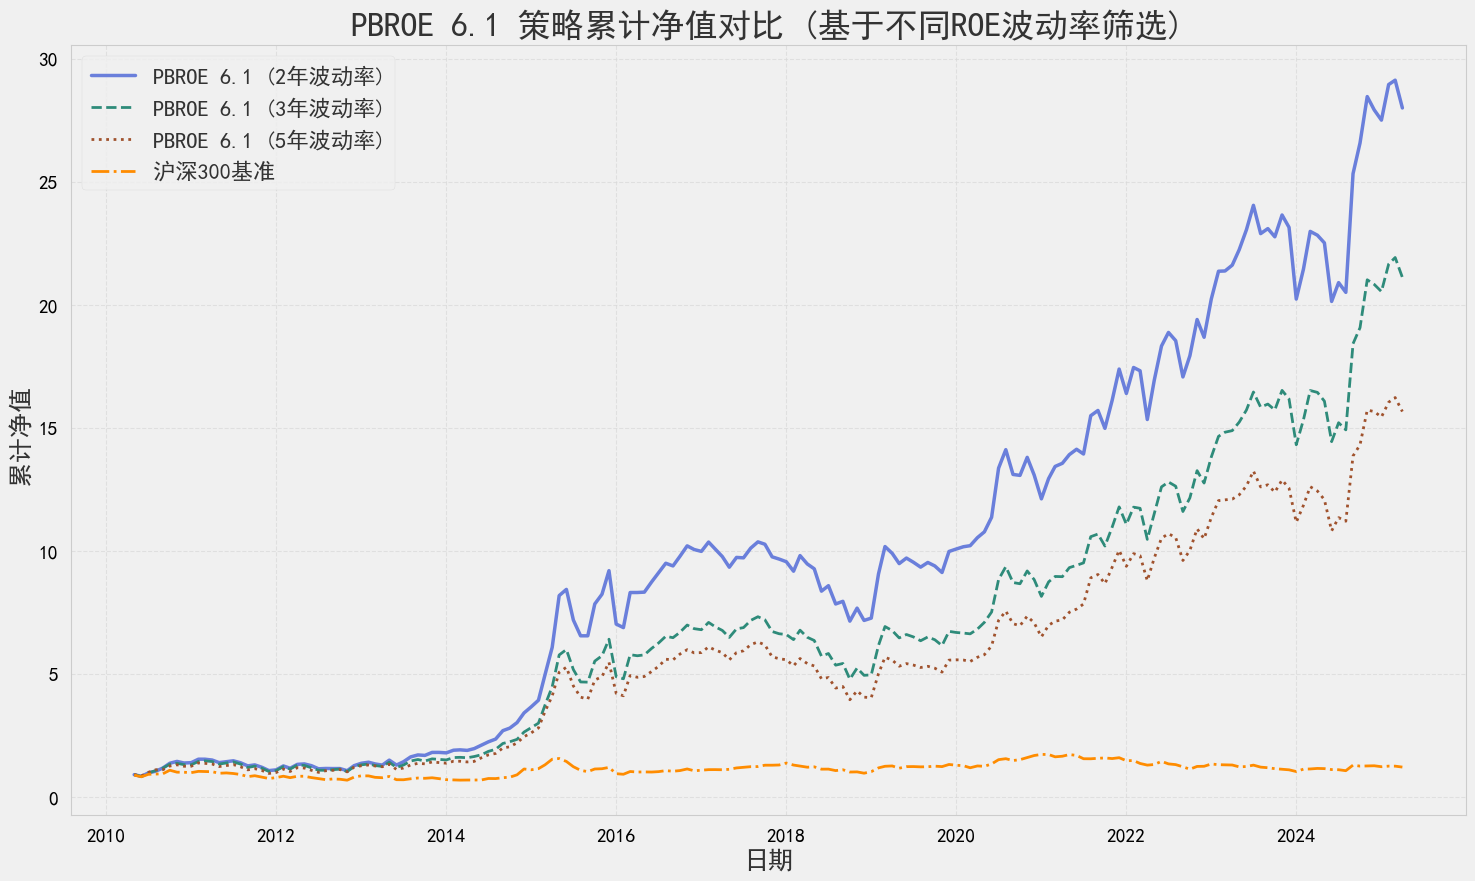

In [5]:
# PBROE6.1绘图
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def set_academic_style():
    """设置图表的全局学术风格，确保中文显示正常。"""
    plt.style.use('seaborn-v0_8-paper')
    # 设置一个包含多种备选字体的列表，以提高跨平台兼容性
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Heiti TC', 'Microsoft JhengHei', 'Arial Unicode MS', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    plt.rcParams['figure.facecolor'] = '#F0F0F0'
    plt.rcParams['axes.facecolor'] = '#F0F0F0'
    plt.rcParams['text.color'] = '#333333'
    plt.rcParams['axes.labelcolor'] = '#333333'
    plt.rcParams['xtick.color'] = '#000000'
    plt.rcParams['ytick.color'] = '#000000'
    plt.rcParams['grid.color'] = '#D9D9D9'
    plt.rcParams['font.size'] = 16 # 设置适中的基础字体大小

def plot_volatility_strategies(csv_file: Path, output_file: Path):
    """
    加载多波动率策略的回测结果并绘制累计净值对比图。

    Args:
        csv_file (Path): 包含回测结果的CSV文件路径。
        output_file (Path): 生成的图表文件的保存路径。
    """
    print(f"--- 开始绘制 PBROE 6.1 策略累计净值图 ---")

    try:
        # 1. 加载数据
        df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
        print(f"成功加载数据文件: {csv_file.name}")
    except FileNotFoundError:
        print(f"错误: 找不到文件 {csv_file}。请检查路径。")
        return
    except Exception as e:
        print(f"加载文件时出错: {e}")
        return

    # 2. 数据准备
    # 计算基准的累计收益
    df['cum_benchmark'] = (1 + df['benchmark_return']).cumprod()

    # 定义要绘制的列和对应的图例标签及样式
    plot_config = {
        'cum_quality_roe_vol_2y': {'label': 'PBROE 6.1 (2年波动率)', 'color': '#6A7FDB', 'linestyle': '-', 'linewidth': 2.5},
        'cum_quality_roe_vol_3y': {'label': 'PBROE 6.1 (3年波动率)', 'color': '#2E8B7A', 'linestyle': '--', 'linewidth': 2.0},
        'cum_quality_roe_vol_5y': {'label': 'PBROE 6.1 (5年波动率)', 'color': '#A0522D', 'linestyle': ':', 'linewidth': 2.0},
        'cum_benchmark':          {'label': '沪深300基准', 'color': '#FF8C00', 'linestyle': '-.', 'linewidth': 2.0}
    }

    # 3. 开始绘图
    set_academic_style()
    plt.figure(figsize=(18, 10))

    for col, style in plot_config.items():
        if col in df.columns:
            plt.plot(df.index, df[col], **style)
        else:
            print(f"警告: 在数据中未找到列 '{col}'，将跳过绘制。")

    # 4. 设置图表属性
    plt.title('PBROE 6.1 策略累计净值对比 (基于不同ROE波动率筛选)', fontsize=24, fontweight='bold')
    plt.xlabel('日期', fontsize=18)
    plt.ylabel('累计净值 ', fontsize=18)
    plt.grid(True, which="both", linestyle='--', alpha=0.7)
    plt.legend(fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)

    # 优化Y轴刻度标签格式
    from matplotlib.ticker import ScalarFormatter
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter())

    # 5. 保存并显示图表
    try:
        output_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"图表已成功保存至: {output_file}")
        plt.show()
    except Exception as e:
        print(f"保存图表时出错: {e}")

if __name__ == '__main__':
    # --- 配置区域 ---
    # 输入的回测结果文件
    INPUT_CSV = Path('E:/PBROE/ch6/pbroe6.1_multi_vol_returns.csv')

    # 输出的图表文件
    OUTPUT_PNG = Path('E:/PBROE/ch6/ch6_pics_pbroe6.1_vol_strategies_cumulative_returns.png')

    # --- 执行绘图 ---
    plot_volatility_strategies(INPUT_CSV, OUTPUT_PNG)
